<a href="https://colab.research.google.com/github/asadali163/NLP-Transformers/blob/main/codebase/NLP_Sentiment_Analysis_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
from transformers import pipeline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split



In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-08-03 09:05:57--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  --.-KB/s    in 0.06s   

2024-08-03 09:05:57 (56.8 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [ ]:
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

### Let's do some sentiment analysis

In [ ]:
classifier("I love this so much!")

[{'label': 'POSITIVE', 'score': 0.9998788833618164}]

In [ ]:
classifier("I hate this so much!")

[{'label': 'NEGATIVE', 'score': 0.9994558691978455}]

In [ ]:
classifier("This is not the good movie.")

[{'label': 'NEGATIVE', 'score': 0.9997990727424622}]

In [ ]:
classifier("The cousre is don't what I have expected")

[{'label': 'NEGATIVE', 'score': 0.9997050166130066}]

In [ ]:
classifier([
    "I love this instructor",
    "The instructor keep telling meet the pre-requisite, which is irritating"
])

[{'label': 'POSITIVE', 'score': 0.999879002571106},
 {'label': 'NEGATIVE', 'score': 0.9997112154960632}]

### Let's now work on our own dataset

In [ ]:
import torch

In [ ]:
# Check the device if available
torch.cuda.is_available()

True

In [ ]:
df = pd.read_csv("AirlineTweets.csv")

In [ ]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df = df[['airline_sentiment', 'text']].copy()

In [ ]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

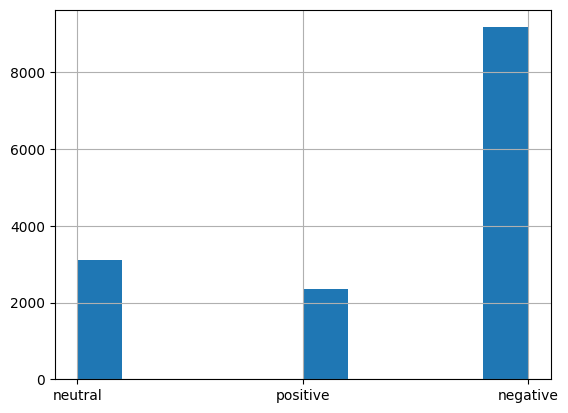

In [ ]:
df['airline_sentiment'].hist()

As you can see we have 3 classes, neutral, positive and negative. The negative is greater then all, surely the data is imbalanced.<br>
We will only use positive and negative for now as huggingface pipeline support positive and negative only

In [ ]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [ ]:
df["airline_sentiment"].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
target_maps = {"positive":1, "negative":0}
df['target'] = df['airline_sentiment'].map(target_maps)

In [ ]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [ ]:
len(df)

11541

In [ ]:
text = df['text'].to_list()
predictions = classifier(text)

In [ ]:
# Let's convert the prediction to 1 and zero
predictions = [1 if pred['label'] == 'POSITIVE' else 0 for pred in predictions]

In [ ]:
# Check the mean accuracy with targets
np.mean(np.array(predictions) == df['target'].to_numpy())

0.8898708950697514

In [ ]:
# Let's check the confusion matrix probability
confusion_matrix(df['target'].to_numpy(), predictions, normalize='true')

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

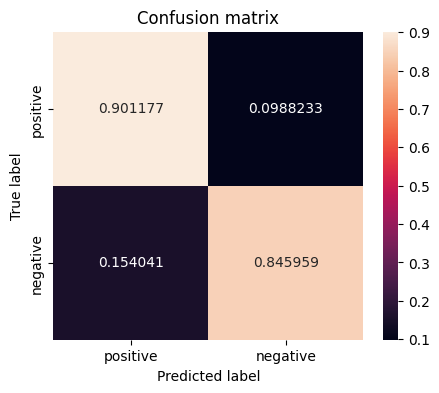

In [ ]:
# Let's plot confusion matrix with heatmap
def plot_cm(cm):
  classes = ['positive', 'negative']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  plt.figure(figsize=(5,4))
  sns.heatmap(df_cm, annot=True, fmt='g')
  plt.title('Confusion matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

plot_cm(confusion_matrix(df['target'].to_numpy(), predictions, normalize='true'))

In [ ]:
f1_score(df['target'].to_numpy(), predictions)

0.7587777566900741

In [ ]:
roc_auc_score(df['target'].to_numpy(), predictions)

0.8735676271257872